In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
# Read Summarisation Model results from json file.

with open("../data/Model_Results/summarisation_results.jsonl", 'r') as json_file:
    json_list = list(json_file)

    
summarisationResults = {}
for json_str in json_list:
    
    result = json.loads(json_str)
    summaryList = sorted(result["sentence_scores"], key=lambda x:x[1], reverse=True)[:4]
    summary = ""
    for sentence in summaryList:
        summary += sentence[0] + ' '
    
    summarisationResults[result["id"]] = summary

In [3]:
summarisationData = pd.DataFrame(data=summarisationResults, index=[0])

In [9]:
summarisationDataDict = {}

for json_id in summarisationData.columns:
    
    features = {}
    
    justDataRow = justificationData.loc[justificationData['json_file_id'] == json_id]
    
    features["summary"] = summarisationData[json_id].values[0]
    
    summarisationDataDict[json_id] = features

In [15]:
summarisationData = pd.DataFrame().from_dict(data=summarisationDataDict)

display(summarisationData)

,11972.json,11685.json,11096.json,5209.json,9524.json,5962.json,7070.json,1046.json,12849.json,13270.json,...,11576.json,3461.json,9464.json,10227.json,11707.json,3425.json,2977.json,294.json,3580.json,8384.json
summary,"""Building a wall"" on the border ""will take lit...","Those numbers show that as of October 2015, th...","If he did, he would have known that Senator Mc...","""…She supports taking $500 billion away from M...","Scott Walker helped run a ""criminal scheme"" to...",The campaign accurately quoted a figure whose ...,"So $30-31 million per year would, in fact, be ...",The Obama administration has emphasized many o...,"""It matters who’s leading the country, and it ...","Pence described the donors as major. ""The nati...",...,We’re not sure Sanders made that entirely clea...,"The $20 million designated for Cuba ""focuses o...",There also are no Asian or Pacific Islander Re...,"""The United States is in the longest stretch o...","""Secretary Clinton changes her position on thi...","Under the header ""New jobs created by the Stre...","They said low pay, increased work demands and ...","• Comstock, an adviser and frequent spokeswoma...","""House Republicans under Paul Ryan's leadershi...","""I will work in a bipartisan way to get it don..."


In [12]:
x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/train.tsv', sep='\t')
x_trainDf.columns = ["json_id", "claim", "justification_label"]

x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/test.tsv', sep='\t')
x_testDf.columns = ["json_id", "claim", "justification_label"]

x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/val.tsv', sep='\t')
x_valDf.columns = ["json_id", "claim", "justification_label"]

In [13]:
x_trainDf["summary"] = ""
x_testDf["summary"]  = ""
x_valDf["summary"]   = ""

In [14]:
def addSummary(data, summaries):
    
    for index, row in data.iterrows():
        if row["json_id"] in summaries.columns:
            row["summary"] = summaries[row["json_id"]].values[0]

In [16]:
addSummary(x_trainDf, summarisationData)
addSummary(x_testDf, summarisationData)
addSummary(x_valDf, summarisationData)

In [18]:
y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
y_valDf   = pd.DataFrame(data=x_valDf["justification_label"])

In [19]:
# Create list containing claims + attention explanations

trainClaimSumm  = []
yTrainLabels   = y_trainDf['justification_label'].tolist()

testClaimSumm   = []
yTestLabels    = y_testDf['justification_label'].tolist()

evalClaimSumm   = []
yEvalLabels    = y_valDf['justification_label'].tolist()

for index, row in x_trainDf.iterrows():
    trainClaimSumm.append(row['claim'] + row['summary'])

for index, row in x_testDf.iterrows():
    testClaimSumm.append(row['claim'] + row['summary'])

for index, row in x_valDf.iterrows():
    evalClaimSumm.append(row['claim'] + row['summary'])
    
totalClaimSumm = trainClaimSumm + testClaimSumm + evalClaimSumm
yTotalLabels = np.array(yTrainLabels + yTestLabels + yEvalLabels)

In [20]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

In [21]:
# Convert words to number using Bag of Words (Bow)
vectorizer = CountVectorizer(max_features=30, min_df=5, max_df=0.7)
vectorizedTrain = vectorizer.fit_transform(trainClaimSumm).toarray()
vectorizedTest  = vectorizer.fit_transform(testClaimSumm).toarray()
vectorizedEval  = vectorizer.fit_transform(evalClaimSumm).toarray()
vectorizedTotal = vectorizer.fit_transform(totalClaimSumm).toarray()

# Convert Bow values according to TfIdf
tfidfconverter = TfidfTransformer()
XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
XTest  = tfidfconverter.fit_transform(vectorizedTest).toarray()
XEval  = tfidfconverter.fit_transform(vectorizedEval).toarray()
XTotal = tfidfconverter.fit_transform(vectorizedTotal).toarray()

              precision    recall  f1-score   support

  distortion       0.57      0.50      0.53         8
    emphasis       0.25      0.22      0.24         9
   unfounded       0.40      0.50      0.44         8

    accuracy                           0.40        25
   macro avg       0.41      0.41      0.40        25
weighted avg       0.40      0.40      0.40        25

0.4


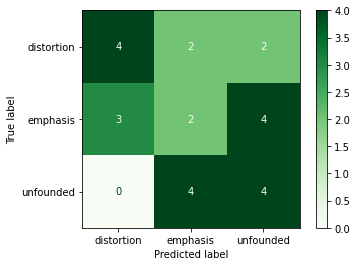

In [22]:
from sklearn.dummy import DummyClassifier

# Dummy Classifier With Method Stratified
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(XTrain, yTrainLabels)

yPredLabels = dummy_clf.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.43      0.38      0.40         8
    emphasis       0.40      0.44      0.42         9
   unfounded       0.38      0.38      0.38         8

    accuracy                           0.40        25
   macro avg       0.40      0.40      0.40        25
weighted avg       0.40      0.40      0.40        25

0.4


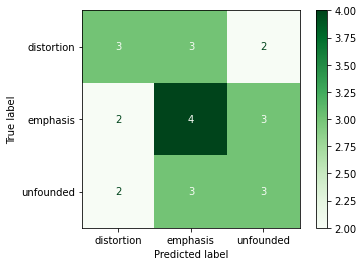

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classification Method
randForestClas = RandomForestClassifier(n_estimators=1000, random_state=0)
randForestClas.fit(XTrain,yTrainLabels)

yPredLabels = randForestClas.predict(XTest)

ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.45      0.62      0.53         8
    emphasis       0.33      0.22      0.27         9
   unfounded       0.62      0.62      0.62         8

    accuracy                           0.48        25
   macro avg       0.47      0.49      0.47        25
weighted avg       0.47      0.48      0.46        25

0.48


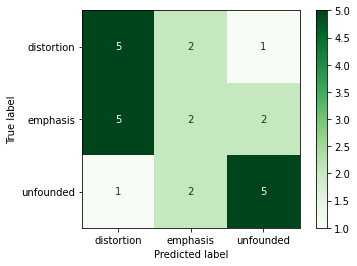

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# K-Neighbors Classifier
kNeighborsClas = KNeighborsClassifier(n_neighbors=7)
kNeighborsClas.fit(XTrain,yTrainLabels)

yPredLabels = kNeighborsClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.67      0.50      0.57         8
    emphasis       0.33      0.22      0.27         9
   unfounded       0.23      0.38      0.29         8

    accuracy                           0.36        25
   macro avg       0.41      0.37      0.37        25
weighted avg       0.41      0.36      0.37        25

0.36


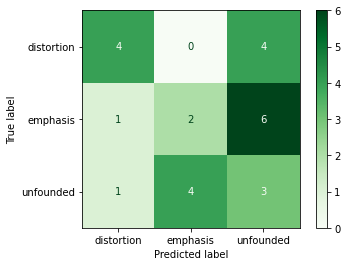

In [25]:
from sklearn.svm import SVC

# SVM Classifier
svmClas = SVC()
svmClas.fit(XTrain,yTrainLabels)

yPredLabels = svmClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.56      0.62      0.59         8
    emphasis       0.33      0.33      0.33         9
   unfounded       0.14      0.12      0.13         8

    accuracy                           0.36        25
   macro avg       0.34      0.36      0.35        25
weighted avg       0.34      0.36      0.35        25

0.36


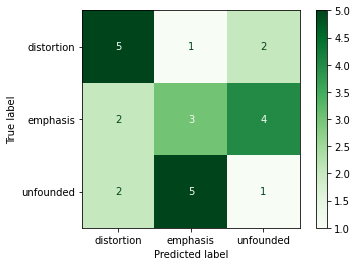

In [26]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier
gaussianProcClas = GaussianProcessClassifier()
gaussianProcClas.fit(XTrain,yTrainLabels)

yPredLabels = gaussianProcClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.25      0.25      0.25         8
    emphasis       0.42      0.56      0.48         9
   unfounded       0.20      0.12      0.15         8

    accuracy                           0.32        25
   macro avg       0.29      0.31      0.29        25
weighted avg       0.29      0.32      0.30        25

0.32


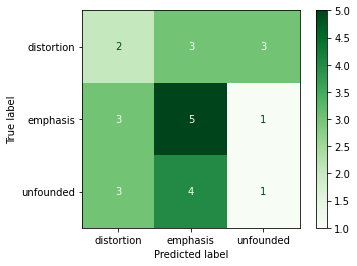

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
decisionTreeClas = DecisionTreeClassifier()
decisionTreeClas.fit(XTrain,yTrainLabels)

yPredLabels = decisionTreeClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.00      0.00      0.00         8
    emphasis       0.42      0.56      0.48         9
   unfounded       0.00      0.00      0.00         8

    accuracy                           0.20        25
   macro avg       0.14      0.19      0.16        25
weighted avg       0.15      0.20      0.17        25

0.2


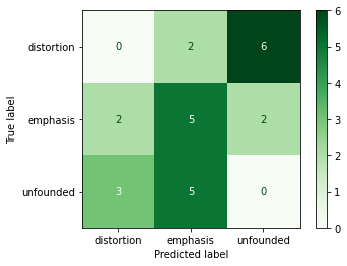

In [28]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier
adaBoostClas = AdaBoostClassifier()
adaBoostClas.fit(XTrain,yTrainLabels)

yPredLabels = adaBoostClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.27      0.38      0.32         8
    emphasis       0.30      0.33      0.32         9
   unfounded       0.25      0.12      0.17         8

    accuracy                           0.28        25
   macro avg       0.27      0.28      0.27        25
weighted avg       0.28      0.28      0.27        25

0.28


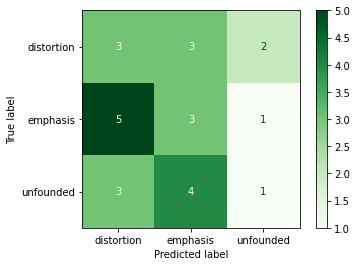

In [29]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Classifier
gaussianNBClas = GaussianNB()
gaussianNBClas.fit(XTrain,yTrainLabels)

yPredLabels = gaussianNBClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))